## Practical 9: Selecting Data

Selecting & Linking Data

> **Important**
>
> This practical focusses on data linkage! You will have seen quite a
> bit of this of these across the preceding three to four weeks, but
> they were picked up in an *ad-hoc* way, here we try to systematise
> things a bit. We’re also going to look at alternatives to loading the
> entire data set into memory in Python: using the DuckDB driver we can
> perform a lot of operations ‘outside’ of Python’s memory and
> processing limits while still benefiting from reproducibility (the
> commands are stored in the Python script) and access (we can bring the
> filtered, linked data into Python when we need to do so).

> **🔗 Connections**
>
> We’re going to look at how data can be joined (linked) to other data
> using a range of techniques: pure Python (spatial and non-spatial) and
> SQL (non-spatial only).

## 1. Preamble

In [1]:
ymd  = '20250615'
city = 'London'
host = 'https://orca.casa.ucl.ac.uk'
url  = f'{host}/~jreades/data/{ymd}-{city}-listings.geoparquet'

In [2]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

from pathlib import Path
from functools import wraps
from time import time

# A timing decorator courtesy of: 
# https://www.geeksforgeeks.org/python/timing-functions-with-decorators-python/
def timing(func):
    def wrap_func(*args, **kwargs):
        t1 = time()
        result = func(*args, **kwargs)
        t2 = time()
        return (t2-t1)
    return wrap_func

In [3]:
from pathlib import Path
from requests import get
from functools import wraps

def check_cache(f):
    @wraps(f)
    def wrapper(src:str, dst:str, min_size=100) -> Path:
        if src.find('?') == -1:
            url = Path(src)
        else:
            url = Path(src[:src.find('?')])
        fn  = url.name  # Extract the filename
        dsn = Path(f"{dst}/{fn}") # Destination filename
        if dsn.is_file() and dsn.stat().st_size > min_size:
            print(f"+ {dsn} found locally!")
            return(dsn)
        else:
            print(f"+ {dsn} not found, downloading!")
            return(f(src, dsn))
    return wrapper

@check_cache
def cache_data(src:Path, dst:Path) -> str:
    """Downloads a remote file.
    
    The function sits between the 'read' step of a pandas or geopandas
    data frame and downloading the file from a remote location. The idea
    is that it will save it locally so that you don't need to remember to
    do so yourself. Subsequent re-reads of the file will return instantly
    rather than downloading the entire file for a second or n-th itme.
    
    Parameters
    ----------
    src : str
        The remote *source* for the file, any valid URL should work.
    dst : str
        The *destination* location to save the downloaded file.
        
    Returns
    -------
    str
        A string representing the local location of the file.
    """
      
    # Create any missing directories in dest(ination) path
    # -- os.path.join is the reverse of split (as you saw above)
    # but it doesn't work with lists... so I had to google how
    # to use the 'splat' operator! os.makedirs creates missing
    # directories in a path automatically.
    if not dst.parent.exists():
        dst.parent.mkdir(parents=True, exist_ok=True)
        
    # Download and write the file
    with dst.open(mode='wb') as file:
        response = get(src)
        file.write(response.content)
        
    print(' + Done downloading...')

    return dst.resolve()

In [4]:
ddir     = Path('data/geo')
pqt      = url.replace('.geo','.')

## 2. Selecting Data in Pandas

In this section we are loading a parquet file using pandas and taking
advantage of Python’s ‘chaining’ functionality
(`<object>.<method>().<method>()...`) to return the first few rows of a
data frame using `head`. The thing to notice is that we’re not even
bothering to save the result of this command into a variable (thus the
lack of a `df =` in the code). We’re doing this here *solely* so that
you can compare pandas and DuckDB performance and syntax across each of
the following steps.

### 2.1 A simple query

In [5]:
@timing
def load(n:int):
    for i in range(n):
        pd.read_parquet(f'{pqt}').head(3)

reps = 10
secs = load(reps)
print(f"Average time per call: {secs/reps:.5f}")

I get an average time per call of about: 0.44767

### 2.2 Selecting columns

To load a columnar subset of the data we have two options:

1.  Load all the data and *then* subset (which always happens with CSV
    files but is optional with other formats)
2.  Load only the columns we care about (which is possible with parquet
    files)

And in code these are implemented as:

#### 2.2.1 Load *then* filter

In [7]:
@timing
def load(n:int):
    for i in range(n):
        pd.read_parquet(f'{pqt}')[['listing_url', 'price', 'number_of_reviews', 'property_type', 'host_name']].head(5)

reps = 10
secs = load(reps)
print(f"Average time per call of about: {secs/reps:.5f}")

I get an average time per call of about: 0.41730

Not bad, not bad…

#### 2.2.2 Filter *then* load

In [9]:
@timing
def load(n:int):
    for i in range(n):
        pd.read_parquet(f'{pqt}', columns=['listing_url', 'price', 'number_of_reviews', 'property_type', 'host_name']).head(5)

reps = 10
secs = load(reps)
print(f"Average time per call of about: {secs/reps:.5f}")

I get an average time per call of about: 0.33091

Whoa! Notice the difference in the time needed to complete the
operation! We just accelerated this step by 0.79 times.!

### 2.3 Adding a constraint

So that is performance for loading data, now let’s see what happens when
we start subsetting the data by *row* as well as by *column*.

In [11]:
@timing
def load(n:int):
    for i in range(n):
        df = pd.read_parquet(f'{pqt}', columns=['listing_url', 'price', 'number_of_reviews', 'property_type', 'host_name'])
        df[(df.price < 250) & (df.number_of_reviews > 0) & (df.property_type=='Entire home/apt')].head(5)

reps = 10
secs = load(reps)
print(f"Average time per call of about: {secs/reps:.5f}")

I get an average time per call of about: 0.32727

For improved legibility you can also write this as:

In [13]:
df = pd.read_parquet(f'{pqt}', columns=['listing_url', 'price', 'number_of_reviews', 'last_review', 'host_name'])
df[
    (df.price < 250) & 
    (df.number_of_reviews > 0) & 
    (df.property_type=='Entire home/apt')
].head(5)

Notice here that we are using three conditions to filter the data *as
well as* a column filter on loading to minimise the amount of data
loaded into memory. Applying the filters simultaneously will also make
it easy to see what you’ve done (you aren’t applying each one
separately) and to adjust the overall cleaning process.

This filter is fairly straightforward and performance should have been
only slightly slower than doing the column subset in the first place,
but things get a bit more complicated when you want to aggregate the
return…

### 2.4 Aggregating the return

There is a *lot* to unpack here, and notice that it takes three steps to
achieve our goal of selecting, grouping, aggregating, sorting, and
printing out the ten most frequent combinations of room and property
type, although we *could* reduce it to two if we really wanted to do so
(at the cost of some legibility).

Average time per call of about: 0.32334

I get an average time per call of about: 0.32371

Hopefully the first two steps are fairly clear, so let’s focus on the
final one:

##### 2.4.0.1 Group By

This is a *reasonably* intelligible step in which we group the data
loaded by room and property:

In [16]:
dfg = df.groupby(
        by=['room_type','property_type'],
        observed=True
    )
dfg

The *order* here matters: `groupby(by=[<A>,<B>])` does not return the
same result as `groupby(by=[<B>,<A>])`. Try it:

In [17]:
df.groupby(
        by=['property_type','room_type'],
        observed=True
    )

The other thing to note here is the `observed=True`. This is a nice bit
of additional functionality that, if you set it to `False` will return a
number for all possible combinations, inserting a zero if that
combintaion is *not* observed in the data. That’s useful if
*non*-observations (i.e. there was no data for this group) is relevant
to your data presentation or subsequent modelling/statistical tests[1].

##### 2.4.0.2 Agg

The `agg` step aggregates the data specified in the functions:

[1] One could imagine, for instance, that you want to present the data
in a table in which case you want the zero because there needs to be a
value for each cell in the table.

In [18]:
dfg.agg(
        freq = ("property_type", "count"),
        median_price = ("price", "median"),
)

Pandas offers a *lot* of different ways to do this, but the above
approach is perhaps the most flexible since we are telling Pandas to
apply the `count` function to the `property_type` field and assign it to
a column called `freq`, and to apply the `median` function to the
`price` field and assign that to a column called `median_price`.

##### 2.4.0.3 ‘Degroup’

In order to do anything further with the aggregated data you will
*almost* always want to convert your `GroupedDataFrame` back to a
regular `DataFrame` and that means resetting the index `reset_index()` –
this is just one of those things to learn about grouped data in Pandas.

##### 2.4.0.4 Sort

Finally, to sort the *data* you need to `sort_values`, where `by`
specifies the fields you want to sort on and `ascending` is a matching
(optional) list that specifies the sort order for each sort column. If
you just want to sort everything in ascending order then you don’t need
to specify the `ascending` values, and if you wanted to sort
*everything* in descending order then it’s just `ascending=False`.

## 3. Selecting Data in DuckDB

That last example may have left you despairing of every being able to
select/filter/aggregate/derive your data, but there *is* another way
that is often far simpler *if* you are: a) willing to learn a different
language, and b) willing to work with data in different formats. And
that’s all thanks to Parquet and DuckDB.

The combination of parquet files and in-memory databases (DuckDB is just
*one* of these) has fundamentally reshaped my workflow. Parquet and
Apache Arrow are [closely related](https://stackoverflow.com/a/56481636)
but, in short, when you want to save large data sets in an
easy-to-access and fast-to-query format then Parquet should be your
default choice. DuckDB gives you a way to treat Parquet files *as*
database **tables** and run queries against it (or them!) using standard
SQL. You can [install DuckDB](https://duckdb.org/#quickinstall) on the
command-line, but you can also query it from within Python using the
appropriate module.

In [19]:
import duckdb as db

### 3.1 A first query

Let’s see a quick demonstration:

In [20]:
query = f'''
SELECT *
FROM read_parquet('{pqt}') 
LIMIT 3;
'''

@timing
def load(n:int):
    for i in range(n):
        db.sql(query)

reps = 25
secs = load(reps)
print(f"Average time per call of about: {secs/reps:.5f}")

I get an average time per call of about: 0.01665

The timing code should *already* show a [significant improvement over
pandas-only code](#a-simple-query): on my laptop it is 10.76 times
faster. Now let’s unpack what’s happening:

1.  We import the `duckdb` library as `db`.
2.  We set up a SQL `query` using a multi-line f-string
3.  We use DuckDb to execute the query and return a pandas dataframe
    (`df`)

What’s particularly elegant here (and quite different from trying to
talk to a Postres or MySQL database) is that there’s no
connect-execute-collect pattern; we just build the query and execute it!

> **I *do* declare…**
>
> Now let’s take a look at the SQL query… SQL is what’s called a
> [declarative
> language](https://en.wikipedia.org/wiki/Declarative_programming),
> meaning that it is about the logic we want the program to follow
> rather than the ‘flow’ of execution. Python supports *some*
> declarative elements but is more commonly seen as an imperative
> language supporting procedural or functional approaches. This is a
> long way of saying: SQL won’t look like Python even though we’re
> executing SQL from *within* Python.

So our query (with added line numbers for clarity) looked liked this:

``` sql
SELECT *
FROM read_parquet('{pqt}') 
LIMIT 3
```

Line-by-line this means:

1.  Select all columns (`*` == everything\>\`)
2.  From the parquet file (`<table location>`)
3.  Limit the return to 3 rows (`LIMIT <row count>`)

Let’s look at some variations…

### 3.2 Selecting columns

In [22]:
query = f'''
SELECT listing_url, price, number_of_reviews, last_review, host_name 
FROM read_parquet('{pqt}') 
LIMIT 5;
'''

@timing
def load(n:int):
    for i in range(n):
        db.sql(query)

reps = 25
secs = load(reps)
print(f"Average time per call of about: {secs/reps:.5f}")

I get an average time per call of about: 0.00013

Even though it looked like pandas performed *massively* better when we
updated our query to [filter then load](#filter-then-load), DuckDB is
**even faster**! I get that DuckDB is 1026.34 faster than pandas.

``` sql
SELECT listing_url, price, number_of_reviews, last_review, host_name 
FROM read_parquet('{pqt}') 
LIMIT 5;
```

It should be fairly easy to see how the query has changed from last
time, but line-by-line this means:

1.  Select a set of columns from the table in the order specified
    (`SELECT <column 1>, <column 30>, <column 5>...`)
2.  From the parquet file (`FROM <table location>`)
3.  Limit the return to 5 rows (`LIMIT <row count>`)

### 3.3 Adding a constraint

In [24]:
query = f'''
SELECT listing_url, price, number_of_reviews, last_review, host_name 
FROM read_parquet('{pqt}') 
WHERE price < 250 
AND number_of_reviews > 0
AND property_type='Entire home/apt'
LIMIT 5;
'''

@timing
def load(n:int):
    for i in range(n):
        db.sql(query)

reps = 25
secs = load(reps)
print(f"Average time per call of about: {secs/reps:.5f}")

I get an average time per call of about: 0.00014

Performance should still be noteable [improvement over
pandas](#adding-a-constraint), though in my simple tests it’s ‘only’
about 30% faster. IF we wanted to be more rigorous about this we’d want
to [repeat the same operation many
times](https://www.browserstack.com/guide/python-performance-testing)
(e.g. hundreds or thousands of time) to account for the fact that during
any given query the computer might be doing other things that impact
performance.

Anyway, in this query we’ve added *three* constraints using a `WHERE`,
which is asking DuckDB to find all of the rows *where* the following
things are true:

1.  The `price` must be less than (\$)250/night
2.  The `number_of_reviews` must be more than 0
3.  The `property_type` must be `Entire home/apt`

### 3.4 Aggregating the return

That’s hopefully enough to get you started on *selecting* data, but
databases ‘excel’ at aggregating data in various ways. We aren’t going
to get into things like windowing functions or stored procedures here,
but even simple aggregates done in DuckDB can vastly improve on the
performance of pandas.

> **Tip**
>
> When you aggregate data you need to retrieve *every* column in the
> `SELECT` portion that you `GROUP BY` in the `WHERE` portion of the
> query. This will make sense when you see the examples below… and
> should also make sense based on the Pandas equivalent above!

In [26]:
query = f'''
SELECT property_type, room_type, 
    COUNT(*) AS frequency, MEDIAN(price) AS median_price
FROM read_parquet('{pqt}') 
WHERE price < 1000 
AND number_of_reviews > 0
GROUP BY room_type, property_type
ORDER BY frequency DESC, room_type, property_type
LIMIT 5;
'''

@timing
def load(n:int):
    for i in range(n):
        db.sql(query)

reps = 25
secs = load(reps)
print(f"Average time per call of about: {secs/reps:.5f}")

I get an average time per call of about: 0.00015

Performance is [comparable to pandas](#aggregating-the-return) in my
very basic test, but I find the operation more clearly expressed in SQL
than pandas. There are quite a few changes to the query here so it’s
worth reviewing them in more detail:

``` sql
SELECT property_type, room_type, 
    COUNT(*) AS freq, MEDIAN(price) AS median_price
FROM read_parquet('{pqt}') 
WHERE price < 1000 
AND number_of_reviews > 0
GROUP BY room_type, property_type
ORDER BY frequency DESC, room_type, property_type
LIMIT 10;
```

Key things to note:

1.  We have two new aggregate *functions*:
    -   `COUNT(*)` returns a count of the number of rows in each group
        specified in the `GROUP BY` clause. We don’t need to specify a
        column here because `*` means ‘all rows’.
    -   `MEDIAN(price)` returns, unsurprisingly, the median value of the
        `price` column for *each* group specified in the `GROUP BY`
        clause.
    -   *Note* also the `AS frequency` which ‘renames’ the column
        returned by the query; it’s the same concept as the
        `import x as y` in Python.
2.  `GROUP BY` is where the aggregation happens, and here we’re asking
    DuckDB to take all of the rows selected
    (`WHERE price < 1000 AND number_of_reviews > 0`) and group them
    using the `room_type` and `property_type` fields.
3.  `ORDER BY` orders the returned records by the columns we specify,
    and they can be either `ASC`ending (the default) or `DESC`ending
    (descending).

What you should also be noting here is that:

-   This query returns *very* quickly compared to the pandas equivalent.
-   We have been able to express our selection, grouping, and organising
    criteria very succinctly.

In terms of both speed and intelligibility, there can be quite
substantial advantages to moving *some* of your workflow into a database
or a database-like format such as Parquet and then querying that from
Python. Databases are *designed* for the kind of application that Pandas
struggles with, and if you get to windowing functions and stored
procedures you’ll see how there are situations where something is far
easier to express in Python/Pandas than in SQL.

So the trick here is to recognise when you are facing a problem that: a)
will benefit from being expressed/tackled in a different language; and
b) won’t create undue overhead on your technology ‘stack’. In working
with environmental and built environment data I was able to cut the
processing time by 80% when I moved the bulk of the data linkage work
from Pandas into Parquet+DuckDB. *But*, by the same token, what’s the
point of using Postgres and managing a spatial database to perform a
single step in a much longer workflow *unless* the performance
considerations are so massive they outweigh any other issue.

## 4. Thinking About Joins

We’re going to look at joining data by attributes *first* and then look
at spatial joins *after* so that you get a sense of how they behave and
differ. However, even where you *do* have a spatial problem, it can be
worth it to manage it as a non-spatial problem to improve the overall
performance of your code.

For instance, say you have data from LSOAs and want to be able to
aggregate it up to MSOA-level to perform various analyses.

##### 4.0.0.1 LSOA Table

| LSOA Code | Polygon |
|----------:|--------:|
|     LSOA1 |  WKT(…) |
|     LSOA2 |  WKT(…) |
|     LSOA3 |  WKT(…) |

##### 4.0.0.2 MSOA Table

| MSOA Code | Polygon |
|----------:|--------:|
|     MSOA1 |  WKT(…) |
|     MSOA2 |  WKT(…) |
|     MSOA3 |  WKT(…) |

The *obvious* way to do this is as a spatial join *something* like this:

``` sql
SELECT m."MSOA Code", SUM(<attribute 1>) AS feature_sum, COUNT(<attribute 2>) AS feature_count  
FROM <lsoa data table> AS l, <msoa data table> AS m  
WHERE ST_Within(l.<lsoa geom>, m.<msoa geom>)
GROUP BY m."MSOA Code";
```

We’ll get to what’s happening with `AS l` and `AS lkp` in a bit more
detail below, but the term for this is *aliasing* and its saves us
having to repeatedly type `<lsoa data table>` by allowing us to use the
alias `l`. But you would run this same query *every* time you wanted to
aggregate something.

**This is *not* the right way to tackle this problem** even though you
can write the query to give you the correct answer. Spatial queries ([as
I said in the pre-recorded
lectures](https://jreades.github.io/fsds/sessions/week9.html#pre-recorded-lectures))
are *hard*, so if you can ‘cache’ the result in a *non*-spatial format
it will save a lot time in the future.

The answer is to run the spatial query *once* in order to create a
‘lookup table’ which uses the LSOA and MSOA *codes* (and you can even
add Boroughs, Regions, OAs, and so on later if you like!) to tell you if
a LSOA falls inside a borough or MSOA. So you perform the hard spatial
query *just once* to create the lookup table, and thereafter you are
using a fast non-spatial query.

In this case your lookup table will look like this…

##### 4.0.0.3 Lookup Table

| LSOA Code | MSOA Code | Borough Code |
|----------:|----------:|-------------:|
|     LSOA1 |     MSOA1 |        BORO1 |
|     LSOA2 |     MSOA1 |        BORO1 |
|     LSOA3 |     MSOA2 |        BORO1 |

Now you can do any kind of *spatial aggregation* you want without having
to incur the costs of running a *spatial query* using something like:

``` sql
SELECT lkp."MSOA Code", SUM(<attribute 1>) AS feature_sum, COUNT(<attribute 2>) AS feature_count  
FROM <lsoa data table> AS l, <lookup table> AS lkp  
WHERE l."LSOA Code" = lkp."LSOA Code" 
GROUP BY lkp."MSOA Code";
```

You can also use this as a foundation for creating a `VIEW` or a
`[MATERIALIZED VIEW](https://www.databricks.com/glossary/materialized-views)`,
but that’s an advanced topic for managing your data more efficiently in
an operational environment rather than a research-oriented one.

> **Spatial DuckDB**
>
> DuckDB also now supports spatial queries via the [`SPATIAL`
> extension](https://duckdb.org/docs/extensions/spatial.html).
> Performance is *not* that of a tuned Postgres+PostGIS database, but
> the overhead of *creating* such a tuned database often exceeds the
> benefit for ad-hoc querying. Basically, Postgres+PostGIS is great if
> you’re a company such as Booking.com, Airbnb, or OpenStreetMap, but
> it’s most likely overkill for offline, read-only applications.

### 4.1 Additional Data

For the rest of this notebook we need three data sets about MSOAs (which
are statistical neighbourhoods that we’ll treat as a proxy for ‘real’
neighbourhoods). The first two are *non*-spatial:

In [28]:
msoa_names_url = 'https://houseofcommonslibrary.github.io/msoanames/MSOA-Names-1.20.csv'
msoa_popst_url = 'https://orca.casa.ucl.ac.uk/~jreades/data/sapemsoaquinaryagetablefinal.xlsx'

msoa_nms = pd.read_csv( cache_data(msoa_names_url, 'data') )

# This one can't be cached because we need to access
# an Excel sheet name and the cache_data function isn't
# smart enough to handle this use case.
msoa_pq = Path('data/MSOA_population_estimates.parquet')
if msoa_pq.exists():
    msoa_df = pd.read_parquet(msoa_pq)
else:
    msoa_df = pd.read_excel(msoa_popst_url, sheet_name="Mid-2022 MSOA 2021", header=3)
    msoa_df.to_parquet(msoa_pq)

print(f"msoa_df  has {msoa_df.shape[0]:,} rows and {msoa_df.shape[1]:,} columns.")
print(f"msoa_nms has {msoa_nms.shape[0]:,} rows and {msoa_nms.shape[1]:,} columns.")

+ data/MSOA-Names-1.20.csv found locally!
msoa_df  has 7,264 rows and 43 columns.
msoa_nms has 7,201 rows and 6 columns.

We also need some geodata:

In [29]:
msoa_gpkg = gpd.read_file( cache_data(f'{host}/~jreades/data/MSOA-2011.gpkg', ddir) ).to_crs('epsg:27700')

+ data/geo/MSOA-2011.gpkg found locally!

> **The preferred solution**
>
> **To keep it simple**: you should assume that non-spatial joins are
> *always* going to be faster than spatial ones, even in a performant
> spatial database. Asking if one number is less than another, or if a
> piece of text is found in another piece of text, is *much* simpler
> than asking if one object falls within the boundaries of another.
> Spatial databases are fast and very cool, but if you can express your
> problem non-spatially it will be faster to solve it that way too.

## 5. Non-Spatial Joins In Pandas

Pandas distinguishes between several types of what SQL would call a
‘join’: the process of linking two data sets. Depending on what you want
to do, this will fall into one of the [merge, join, concatenate, or
compare](https://pandas.pydata.org/docs/user_guide/merging.html)
functions:

-   `concat` simply appends one data frame to another and won’t be
    discussed further, but keep in mind that you can concatenate
    horizontally and vertically (across and down), and that having named
    indexes can cause consternation. You would find it most useful for
    appending columns to a data set (appending rows should be approached
    differently) or extending a data set for year $n$ with data from
    year $n+1$…
-   `merge` is what we normally want when we want to do something
    similar to a SQL join. You should refer back to the lecture for the
    differences between ‘one-to-one’, ‘one-to-many’, and ‘many-to-many’.
    Note too that merging is a function of the pandas library and *not*
    a method of a data frame.

### 5.1 Joining by attribute

So in our case, to join the two MSOA data sets we’re going to need to
match the MSOA codes which have (slightly) different names in the two
datasets:

In [30]:
%%time

rs = pd.merge(msoa_df, msoa_nms[['msoa11cd','msoa11hclnm','Laname']], left_on='MSOA 2021 Code', right_on='msoa11cd', how='left')
print(f"Result set has {rs.shape[0]:,} rows and {rs.shape[1]:,} columns.")
rs.head(3)

Result set has 7,264 rows and 46 columns.
CPU times: user 3.3 ms, sys: 0 ns, total: 3.3 ms
Wall time: 3.3 ms

3 rows × 46 columns

**But wait!** There’s an issue lurking in the data!

In [31]:
print(f"There are {rs.msoa11hclnm.isna().sum()} missing MSOA Names!")

There are 184 missing MSOA Names!

Can you work out why this has happened? There is a clue in the column
names!

There’s no way to solve this problem except by changing the code to use
[this URL
instead](https://houseofcommonslibrary.github.io/msoanames/MSOA-Names-Latest2.csv)
for the MSOA Names.

### 5.2 Constraining the Join

We can also try to constrain the result set to one LA thanks to data in
the MSOA Names database:

In [32]:
%%time 

la_nm = 'Waltham Forest'
sdf   = msoa_nms[msoa_nms.Laname==la_nm][['msoa11cd','msoa11hclnm','Laname']].copy()

rs = pd.merge(msoa_df, sdf, left_on='MSOA 2021 Code', right_on='msoa11cd', how='inner')
print(f"Result set has {rs.shape[0]:,} rows and {rs.shape[1]:,} columns.")
rs.head(3)

Result set has 28 rows and 46 columns.
CPU times: user 1.87 ms, sys: 100 μs, total: 1.97 ms
Wall time: 1.95 ms

3 rows × 46 columns

Without the `how=inner`, the result set would still have all of the rows
but some of the columns would be nearly completely empty.

## 6. Non-Spatial Joins in DuckDB

SQL-based joins use very similar keywords (since Pandas is ‘copying’
SQL), but how we put together the query is quite different.

#### 6.0.1 Joining by attribute

In [33]:
%%time

query = f'''
SELECT * 
FROM 
    read_parquet('data/MSOA_population_estimates.parquet') as n 
LEFT JOIN 
    read_csv('{cache_data(msoa_names_url, 'data')}', header=true) as m
ON 
    n."MSOA 2021 Code"=m.msoa11cd;
'''

db.sql(query).to_df().head(3)

+ data/MSOA-Names-1.20.csv found locally!
CPU times: user 36.9 ms, sys: 5.28 ms, total: 42.2 ms
Wall time: 44.8 ms

3 rows × 49 columns

> **Slower???**
>
> *Without* the data caching function, the query above may *appear*
> slower than the Pandas one but if you look at the timing information
> you’ll see that the actual time spent processing the data was less.
> How can that be? Notice that above we’re reading the CSV file from the
> House of Commons library as *part* of the join, so most of that delay
> is spent waiting for the CSV file to download! Another reason is that
> the files aren’t being loaded into memory *first*, but are being read:
> on small files this allows pandas to outperform DuckDB, but as the
> file size grows the performance profile will change radically.
>
> Anyway, the download penalty is why I prefer to download a file *once*
> and save it locally rather than downloading the same file again and
> again. Plus it’s friendlier (and cheaper!) to the person or
> organisation providing the data to you.

Let’s take a look at the SQL:

``` sql
SELECT * 
FROM 
    read_parquet('data/MSOA_population_estimates.parquet') as n 
LEFT JOIN 
    read_csv(msoa_names_url, header=true) as m
ON 
    n."MSOA 2021 Code"=m.msoa11cd;
```

Line-by-line:

1.  `SELECT` every column (this is the `*`, change this if you want to
    only pull a subset of columns)
2.  `FROM` the following tables (it doesn’t really matter if the tables
    are on this line or the next for legibility)
3.  `<table 1 from parquet> as n` (we can now refer to the data from
    this table using the ‘alias’ `n.`; e.g. `n.Total`)
4.  `LEFT JOIN` as a concept was been covered [in the
    lecture](https://jreades.github.io/fsds//sessions/week9.html)
5.  `<table 2 from csv> as m` (we now refer to the data from this table
    using the alias `m.`; e.g. `m.geometry`)
6.  `ON <left table matching column> = <right table matching column>`
    (here, the unusual thing is the double-quotes around the column name
    required to deal with the fact that the name contains spaces).

*Notice* how there are parallels between even quite different languages
here: if you have spaces or special characters or whatever in your
column name then you’re going to need to handle that a little
differently, and if you have two tables to join you have a left (aka
first) one and a right (aka second) one and the order matters.

### 6.1 Constraining the Join

Now, running the same query to get the Waltham Forest data can be done
two ways:

In [34]:
%%time

boro = 'Waltham Forest'
query = f'''
SELECT * 
FROM 
    read_parquet('data/MSOA_population_estimates.parquet') as n 
INNER JOIN 
    read_csv('{cache_data(msoa_names_url, 'data')}', header=true) as m
ON 
    n."MSOA 2021 Code"=m.msoa11cd
WHERE 
    m.Laname='{boro}';
'''

db.sql(query).to_df().head(3)

+ data/MSOA-Names-1.20.csv found locally!
CPU times: user 27.6 ms, sys: 5.48 ms, total: 33.1 ms
Wall time: 34.2 ms

3 rows × 49 columns

Everything here is *basically* the same except for:

1.  We changed the `LEFT JOIN` to an `INNER JOIN` – this should make
    sense to you if you’ve watched the lectures.
2.  We added a `WHERE m.Laname=<borough name>` which restricts the match
    to only those rows where the Local Authority name is Waltham Forest.

*However*, note that this query can *also* be written this way:

In [35]:
%%time

boro = 'Waltham Forest'
query = f'''
SELECT * 
FROM 
    read_parquet('data/MSOA_population_estimates.parquet') as n, 
    read_csv('{cache_data(msoa_names_url, 'data')}', header=true) as m
WHERE m.Laname='{boro}'
AND n."MSOA 2021 Code"=m.msoa11cd;
'''

db.sql(query).to_df().head(3)

+ data/MSOA-Names-1.20.csv found locally!
CPU times: user 29.2 ms, sys: 3.57 ms, total: 32.8 ms
Wall time: 32.3 ms

3 rows × 49 columns

The second way is a little easier to read, but it *only* allows you to
do **inner joins** where attributes need to match in both tables for a
row to be kept. This situation is such a common ‘use case’ that it makes
sense to have this simpler syntax, but the previous code will work for
inner, left, right, and outer joins.

## 7. Spatial Joins in Geopandas

Let’s try to find all of the listings that fall within the borough of
Waltham Forest.

In [36]:
listings = gpd.read_parquet( cache_data(url, ddir) ).to_crs('epsg:27700')

+ data/geo/20250615-London-listings.geoparquet found locally!

This query implies two steps:

1.  Subset the MSOA geo-data so that it only includes the Waltham Forest
    MSOAs.
2.  Run a spatial query to find the listings that are within those MSOAs
    (we could, optionally, `union` the MSOAs to get the outline of the
    borough)

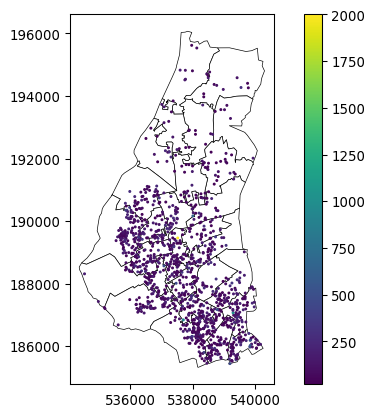

In [37]:
boro = 'Waltham Forest'
boro_gdf = msoa_gpkg[msoa_gpkg.LAD11NM==boro].copy()

# Do the spatial join
boro_listings = gpd.sjoin(listings, boro_gdf, predicate='within', rsuffix='_r')

# Layer the plots
f, ax = plt.subplots(1,1,figsize=(8,5))
boro_gdf.plot(color="white", edgecolor="black", linewidth=0.5, ax=ax)
boro_listings.plot(column='price', cmap='viridis', legend=True, s=1.5, aspect=1, ax=ax)

> **Warning**
>
> If you get `ValueError: aspect must be finite and positive` when you
> try to make a plot (this seems fairly common with `.gpkg` files) then
> you will need to specify `aspect=1` in the `plot(...)` command.

## 8. Spatial Joins in SQL

After quite a bit of faff my conclusion is that, while you *can* do
spatial queries in DuckDB it is a lot of work and *probably* not worth
the effort *at this time*. The ‘issue’ is that spatial support is
provided via the `GDAL` framework and this takes quite a different
approach. After working it out, spatial queries do work *fairly* well if
you do them *entirely* within DuckDB (reading, merging, and writing the
data) and then load the results in a separate step using GeoPandas;
however, you *cannot* get a GeoDataFrame back via
`db.query(<query>).to_df()` since that *only* returns a Pandas data
frame and the geometry column is unreadable. In addition, geoparquet
support seems limited while GeoPackage performance is *poor*, so you’re
basically losing all the advantages of a parquet-based workflow.

So the example is provided for reference only when you need to work with
a geospatial data format and, on the whole, right now I’d recommend
using GeoPandas and geoparquet files directly. In fact, if you read
closely you’ll realise that this isn’t even a spatial join, it’s just
outputting spatially-referenced data!

+ data/geo/MSOA-2011.gpkg found locally!
+ data/MSOA-Names-1.20.csv found locally!
Result set has 28 rows and 4 columns.
CPU times: user 442 ms, sys: 150 ms, total: 592 ms
Wall time: 750 ms

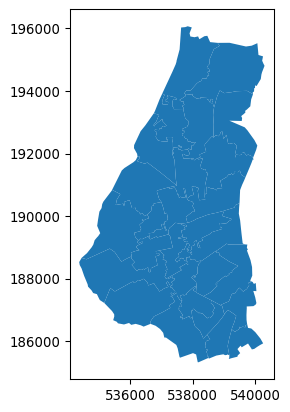

In [38]:
%%time

boro = 'Waltham Forest'

query = f'''
INSTALL SPATIAL;
LOAD SPATIAL;
COPY(
  SELECT m.MSOA11CD, n.msoa11nm, n.Laname, m.geom 
  FROM 
      (SELECT MSOA11CD, geom FROM ST_Read("{cache_data(f'{host}/~jreades/data/MSOA-2011.gpkg', ddir)}")) AS m,
      read_csv("{cache_data(msoa_names_url, 'data')}") AS n
  WHERE m.MSOA11CD=n.msoa11cd
  AND n.Laname='{boro}'
) TO 'data/geo/merged.gpkg' WITH (FORMAT GDAL, DRIVER 'GPKG', LAYER_CREATION_OPTIONS 'WRITE_BBOX=YES');
'''

db.sql(query)
rs = gpd.read_file('data/geo/merged.gpkg')
print(f"Result set has {rs.shape[0]:,} rows and {rs.shape[1]:,} columns.")
rs.head(5)
rs.plot(aspect=1)

## 9. Worked Example

Let’s now try work through a practical example that combines everything
we’ve just learned.

### 9.1 Load Geodata

A lot of additional geo-data can be accessed from the
[GeoPortal](https://geoportal.statistics.gov.uk/). And see also [my
discussion](https://jreades.github.io/fsds/sessions/week8.html) on
[lookup
tables](https://geoportal.statistics.gov.uk/datasets/postcode-to-output-area-to-lower-layer-super-output-area-to-middle-layer-super-output-area-to-local-authority-district-november-2018-lookup-in-the-uk-2/about).
For demonstration purposes we’re going to work the same set of files ‘as
usual’:

In [39]:
spath = 'https://github.com/jreades/fsds/blob/master/data/src/' # source path
water = gpd.read_file( cache_data(spath+'Water.gpkg?raw=true', ddir) )
boros = gpd.read_file( cache_data(spath+'Boroughs.gpkg?raw=true', ddir) )
green = gpd.read_file( cache_data(spath+'Greenspace.gpkg?raw=true', ddir) )
msoas = gpd.read_file( cache_data(f'{host}/~jreades/data/MSOA-2011.gpkg', ddir) ).to_crs('epsg:27700')

+ data/geo/Water.gpkg found locally!
+ data/geo/Boroughs.gpkg found locally!
+ data/geo/Greenspace.gpkg found locally!
+ data/geo/MSOA-2011.gpkg found locally!

### 9.2 Select London MSOAs

> **🔗 Connections**
>
> One thing to remember here is that computers are *exact*. So if you
> say that the selection should only be of MSOAs *within* London then
> you actually need to think about whether a shared border qualifies as
> ‘within’. Watch [the
> lectures](https://jreades.github.io/fsds/sessions/week9.html#pre-recorded-lectures)
> again if you’re unsure, but that’s why here we take this slightly
> clunky approach of buffering the London boundary *before* doing the
> selection.

#### 9.2.1 Union

As we don’t have a boundary file for London, we can *generate* use using
the `union` operator (as we do here) or using the
[dissolve()](https://geopandas.org/en/stable/docs/user_guide/aggregation_with_dissolve.html)
approach. Consider the pros and cons of each approach in terms of
performance, output format, and legibility.

So here’s approach 1, which is a method call returning a GeoDataFrame
(which is why we can call `plot`):

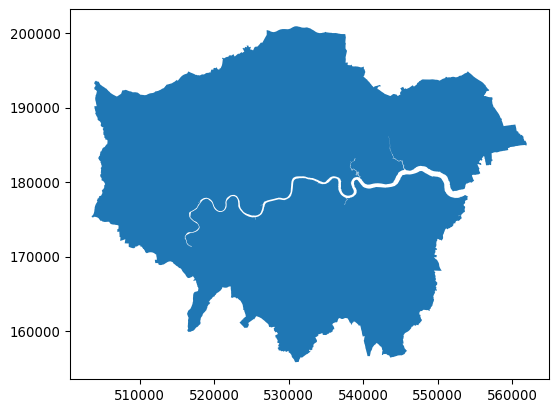

In [40]:
boros.dissolve().plot();

And here’s approach 2, which is an *attribute* and returns a raw polygon
(so no reason to call `plot`, but it’s come back without the rest of the
data frame!):

In [41]:
boros.union_all()

> **🔗 Connections**
>
> Notice how we’re also demonstrating some additional ways of plotting
> ‘on the fly’ (without generating a data frame) as well as (below)
> showing you how to zoom in/out.

### 9.3 Selecting London MSOAs

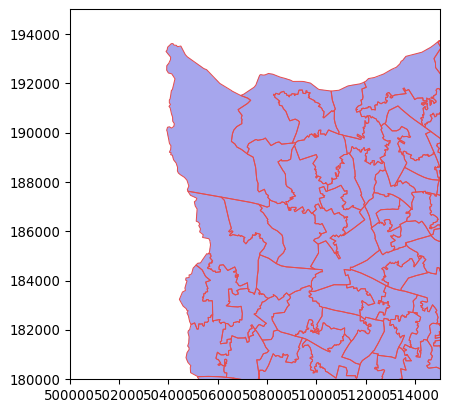

In [42]:
ldn = gpd.GeoDataFrame(gpd.GeoSeries(data=boros.union_all())).rename(columns={0:'geometry'}).set_geometry("geometry")
ldn = ldn.set_crs(epsg=27700)
ax  = ldn.plot(facecolor=(.5, .5, .9, .7))
msoas.plot(ax=ax, facecolor='none', edgecolor=(.9, .3, .3), linewidth=0.75)
ax.set_xlim(500000, 515000)
ax.set_ylim(180000, 195000);

#### 9.3.1 A (Bad) First Join

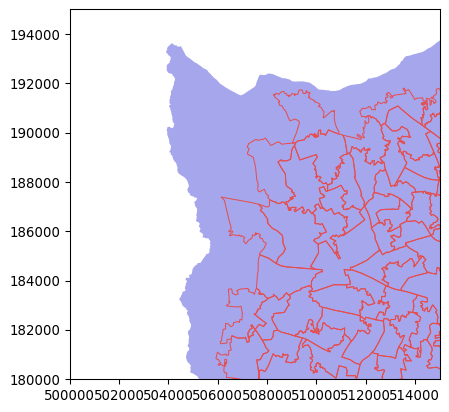

In [43]:
ldn_msoas = gpd.sjoin(msoas, ldn, predicate='within', how='inner')
ax = ldn.plot(facecolor=(.5, .5, .9, .7))
ldn_msoas.plot(ax=ax, facecolor='none', edgecolor=(.9, .3, .3), linewidth=0.75)
ax.set_xlim(500000, 515000)
ax.set_ylim(180000, 195000);

> **What has gone wrong???**
>
> Before you move on to the solution, stop and actually *think* about
> why this hasn’t worked as you might (sensibly) have expected? This is
> another reason that you need to pay close attention to the differences
> between spatial and non-spatial joins.

#### 9.3.2 Buffer and Join

In order to ensure that we get all the MSOAs *within* London we need to
buffer the boundary by some amount to ensure that `within` returns what
we want. If *cover* were easier to use then that option might be
preferable.

##### 9.3.2.1 Question

In [ ]:
ldn['buffered'] = ldn.geometry.???(???)
ldn = ldn.set_geometry('buffered').set_crs(epsg=27700)
ax  = ldn.plot(facecolor=(.5, .5, .9, .5))
msoas.plot(ax=ax, facecolor='none', edgecolor=(.6, .6, .6, .6))
ax.set_xlim(500000, 515000)
ax.set_ylim(180000, 195000);

By default we want do an *inner* join because we want to drop everything
that doesn’t line up between the two data sets (i.e. don’t keep the
thousands of *other* non-London MSOAs).

##### 9.3.2.2 Question

In [ ]:
ldn_msoas = gpd.sjoin(msoas, ldn, predicate='???', how='inner')
ldn_msoas.plot()

Your result should be:

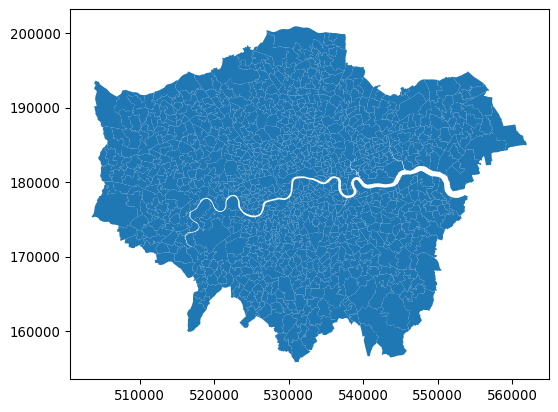

#### 9.3.3 Important Note

If your plot above looks like the output from `pandas` and not
`geopandas` then the list of columns and the documentation for
`set_geometry` might help you to understand what is going wrong:

In [49]:
print(", ".join(ldn_msoas.columns.to_list()))

MSOA11CD, MSOA11NM, LAD11CD, LAD11NM, RGN11CD, RGN11NM, USUALRES, HHOLDRES, COMESTRES, POPDEN, HHOLDS, AVHHOLDSZ, geometry, index_right, geometry_right

It’s important to recognise that `join` and `sjoin` are *not* the same
even though they may effectively perform the same function. An issue can
arise if we join two *geodata* frames using the join function from
`pandas`. The latter doesn’t know anything about spatial data and we can
therefore ‘lose track’ of the geometry column. *Worse*, there are
actually two geometry columns now, so we need to tell Geopandas which
one to use!

The easiest way to do this is to simply rename the geometry we *want*
and then set is as the active geometry. Here’s the code to use if you
have a `geometry_left` column and aren’t able to show a map:

In [50]:
ldn_msoas = ldn_msoas.rename(columns={'geometry_left':'geometry'}).set_geometry('geometry')
ldn_msoas.drop(columns='geometry_right', inplace=True)

We also no longer really need to keep the full MSOA data set hanging
about.

In [51]:
try:
    del(msoas)
except NameError:
    print("msoas already deleted.")

##### 9.3.3.1 Question

-   Can you explain *why* the outputs of the `dissolve` and `union_all`
    *look* differnet? And use that as the basis for explaining why they
    *are* different?

> Answer 1

-   How do you know that the units for the buffering operation are
    metres? 250 could be *anything* right?

> Answer 2

-   Why do we need to buffer the London geometry *before* performing the
    *within* spatial join?

> Answer 3

### 9.4 Create Borough and Regional Mappings

We don’t actually make use of these in this session, but *both*
operations could be relevant to your final reports:

1.  The Borough-to-Subregion mapping could help you to group your data
    into larger sets so that your resulst become more reobust. it also
    connects us to long-run patterns of socio-economic development in
    London.
2.  The MSOA Names data set (which you used above) gives you something
    that you could use to label one or more ‘neighbourhoods’ on a map
    with names that are *relevant*. So rather than talking about “As you
    can see, Sutton 003, is…”, you can write “The Wrythe area of Sutton
    is significantly different from the surrounding areas…”

They also usefully test your understanding of regular expressions and a
few other aspects covered in previous weeks.

#### 9.4.1 Replace

You’ve done this before: notice that the MSOA Name *contains* the
Borough name **with a space and some digits at the end**. Use a regex
(in `str.replace()`) to extract the LA name from the MSOA name. See if
you do this *without* having to find your previous answer!

##### 9.4.1.1 Question

In [ ]:
ldn_msoas['Borough'] = ldn_msoas.MSOA11NM.str.replace(r'???','',regex=True)

# Just check results look plausible; you should have:
# - 33 boroughs
# - A df shape of 983 x 13
print(ldn_msoas.Borough.unique())
print(f"There are {len(ldn_msoas.Borough.unique())} boroughs.")
print(f"Overall shape of data frame is {' x '.join([str(x) for x in ldn_msoas.shape])}")

#### 9.4.2 Map

Now that we’ve got the borough names we can set up a `mapping` dict here
so that we can apply it as part of the `groupby` operation below (you
should have 33 keys when done):

In [54]:
mapping = {}
for b in ['Enfield','Waltham Forest','Redbridge','Barking and Dagenham','Havering','Greenwich','Bexley']:
    mapping[b]='Outer East and North East'
for b in ['Haringey','Islington','Hackney','Tower Hamlets','Newham','Lambeth','Southwark','Lewisham']:
    mapping[b]='Inner East'
for b in ['Bromley','Croydon','Sutton','Merton','Kingston upon Thames']:
    mapping[b]='Outer South'
for b in ['Wandsworth','Kensington and Chelsea','Hammersmith and Fulham','Westminster','Camden']:
    mapping[b]='Inner West'
for b in ['Richmond upon Thames','Hounslow','Ealing','Hillingdon','Brent','Harrow','Barnet','City of London']:
    mapping[b]='Outer West and North West'
print(len(mapping.keys()))

33

##### 9.4.2.1 Question

In [ ]:
ldn_msoas['Subregion'] = ldn_msoas.Borough.map(???)

#### 9.4.3 And Save

In [57]:
ldn_msoas.to_parquet(ddir / 'London_MSOA_Names.geoparquet')

### 9.5 Spatial Join

Associate LA (Local Authority) names to the listings using a spatial
join, but **notice** the `how` here:

##### 9.5.0.1 Question

In [ ]:
gdf_la = gpd.sjoin(listings, ???, predicate='???', how='left')
print(gdf_la.columns.to_list())

#### 9.5.1 Tidy Up

In [60]:
gdf_la.drop(columns=['index_right','HECTARES','NONLD_AREA','ONS_INNER'], inplace=True)

You’ll need to look closely to check that the `value_counts` output
squares with your expectations. If you don’t get `33` then there’s an
issue and you’ll need to run the code in
<a href="#sec-problems" class="quarto-xref">Section 9.5.2</a>:

In [61]:
if len(gdf_la.NAME.unique()) == 33:
    print("All good...")
else:
    print("Need to run the next section of code...")
    print(f"Now there are... {len(gdf_la.NAME.unique())} boroughs?")
    gdf_la.NAME.value_counts(dropna=False)

All good...

#### 9.5.2 Find Problematic Listings

If you were told that you need to run the next section of code then see
if you can work out what happened…

In [62]:
try:
    print(gdf_la[gdf_la.NAME.isna()].sample(2)[['name', 'NAME']])
    ax = gdf_la[gdf_la.NAME.isna()].plot(figsize=(9,6), markersize=5, alpha=0.5)
    boros.plot(ax=ax, edgecolor='r', facecolor='None', alpha=0.5);
except ValueError as e:
   pass

In short: in some cases there may be records that fall outside of London
because of Airbnb’s shuffling approach:

In [63]:
gdf_la.drop(index=gdf_la[gdf_la.NAME.isna()].index, axis=1, inplace=True)
print(f"Data frame is {gdf_la.shape[0]:,} x {gdf_la.shape[1]}")

#### 9.5.3 Check and Save

In [64]:
ax = gdf_la.plot(column='NAME', markersize=0.5, alpha=0.5, figsize=(9,7))
boros.plot(ax=ax, edgecolor='r', facecolor='None', alpha=0.5);

You should get the following:

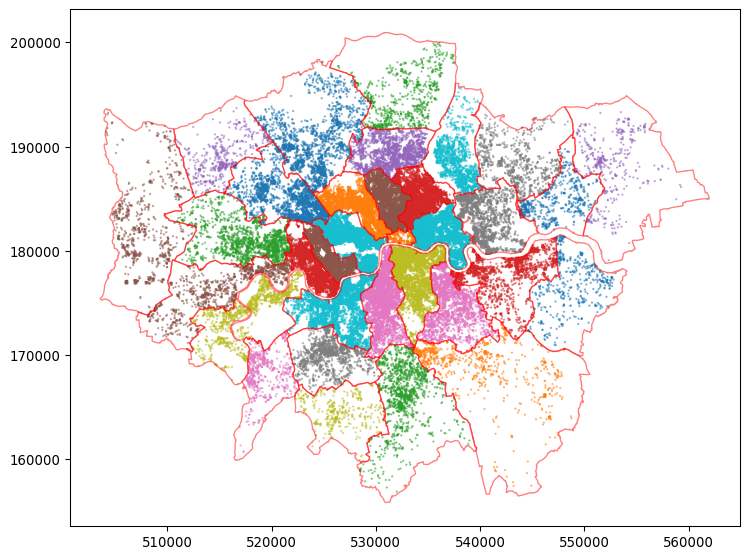

In [66]:
gdf_la.to_parquet(ddir / 'Listings_with_LA.geoparquet')

##### 9.5.3.1 Question

-   Do you understand the difference between `how='inner'` and
    `how='left'`?

> 

### 9.6 Create LA Data

Now that we’ve assigned every listing to a borough, we can derive
aggregate values for different groups of zones.

#### 9.6.1 Select LA

Select a LA that is relevant to *you* to explore further…

In [67]:
LA = 'Waltham Forest'

#### 9.6.2 Spatial Join

The first thing we want to do is join MSOA identifiers to each listing.
In both cases we want to constrain the data to only be for ‘our’ LA of
interest since that will speed up the process substantially:

In [68]:
gdf_msoa = gpd.sjoin(
            gdf_la[gdf_la.NAME==LA].reset_index(), 
            ldn_msoas[ldn_msoas.Borough==LA][['MSOA11CD','MSOA11NM','USUALRES','HHOLDS','Subregion','geometry']], predicate='within')
gdf_msoa.head(2)

2 rows × 42 columns

#### 9.6.3 Aggregate

Now aggregate the data by MSOA, deriving median price and a count of the
listings:

In [69]:
grdf_msoa = gdf_msoa.groupby('MSOA11NM').agg(
    listing_count = ('price','count'),
    median_price = ('price','median')
).reset_index()
print(f"Have {grdf_msoa.shape[0]:,} rows and {grdf_msoa.shape[1]:,} columns")
grdf_msoa.head(2)

Have 28 rows and 3 columns

#### 9.6.4 Join (Again)

Here we see the **difference between merge and join**. You’ll notice
that `join` operates by taking one data frame as the implicit ‘*left*’
table (the one which *calls* join) while the one that is passed to the
join function is, implicitly, the ‘*right*’ table. Join operates only
using indexes, so you’ll need to insert the code to specify the same
index on both data frames, but this can be done **on-the-fly** as part
of the joining operation:

In [70]:
msoa_gdf = grdf_msoa.set_index('MSOA11NM').join(
                ldn_msoas[ldn_msoas.Borough==LA].set_index('MSOA11NM'), 
                rsuffix='_r').set_geometry('geometry')
msoa_gdf.head(3)

In [71]:
msoa_gdf.plot(column='median_price', legend=True, figsize=(8,8));

You should get something like:

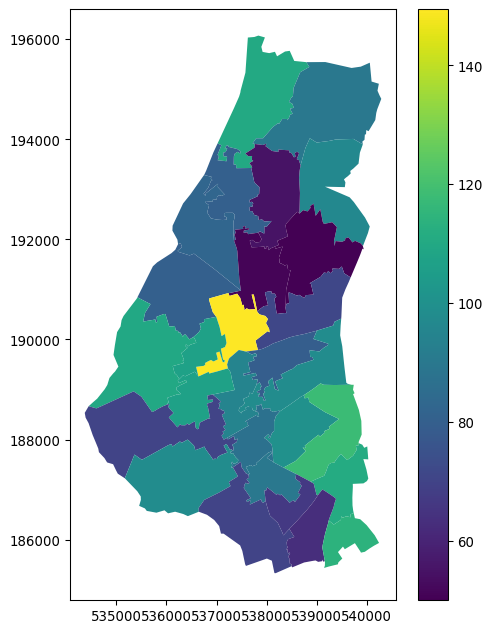

#### 9.6.5 Save

Just so that we can pick up here without having to re-run all the
preceding cells.

In [73]:
msoa_gdf.to_parquet(ddir / f'{LA}-MSOA_data.geoparquet')

##### 9.6.5.1 Question

-   Do you understand the differences between `pd.merge` and `df.join`?
    and `gpd.sjoin`?

> 

-   Do you understand why it may be necessary to `set_geometry` in some
    cases?

>